In [ ]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

!tar -xvf LJSpeech-1.1.tar.bz2

Streaming output truncated to the last 5000 lines.
LJSpeech-1.1/wavs/LJ022-0089.wav
LJSpeech-1.1/wavs/LJ030-0192.wav
LJSpeech-1.1/wavs/LJ041-0078.wav
LJSpeech-1.1/wavs/LJ045-0249.wav
LJSpeech-1.1/wavs/LJ034-0035.wav
LJSpeech-1.1/wavs/LJ010-0152.wav
LJSpeech-1.1/wavs/LJ036-0174.wav
LJSpeech-1.1/wavs/LJ035-0076.wav
LJSpeech-1.1/wavs/LJ032-0176.wav
LJSpeech-1.1/wavs/LJ046-0113.wav
LJSpeech-1.1/wavs/LJ017-0096.wav
LJSpeech-1.1/wavs/LJ004-0098.wav
LJSpeech-1.1/wavs/LJ010-0147.wav
LJSpeech-1.1/wavs/LJ042-0230.wav
LJSpeech-1.1/wavs/LJ041-0033.wav
LJSpeech-1.1/wavs/LJ045-0229.wav
LJSpeech-1.1/wavs/LJ014-0199.wav
LJSpeech-1.1/wavs/LJ002-0082.wav
LJSpeech-1.1/wavs/LJ006-0055.wav
LJSpeech-1.1/wavs/LJ045-0120.wav
LJSpeech-1.1/wavs/LJ050-0028.wav
LJSpeech-1.1/wavs/LJ045-0215.wav
LJSpeech-1.1/wavs/LJ013-0121.wav
LJSpeech-1.1/wavs/LJ008-0025.wav
LJSpeech-1.1/wavs/LJ005-0240.wav
LJSpeech-1.1/wavs/LJ044-0026.wav
LJSpeech-1.1/wavs/LJ048-0127.wav
LJSpeech-1.1/wavs/LJ006-0195.wav
LJSpeech-1.1/wavs/LJ030-0

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import librosa
import os

In [ ]:
class LJSpeechPreprocessor():

  def __init__(self, data_dir, num_samples=None):
    self.data_dir = data_dir
    self.metadata = self.read_metadata(num_samples)

  def read_metadata(self, num_samples):
    """Read meta data"""
    fpath = os.path.join(self.data_dir, "metadata.csv")
    metadata = pd.read_csv(fpath, sep='|', header=None, quoting=3)
    metadata.columns = ["ID", "Transcription", "Normalized Transcription"]
    metadata = metadata[["ID", "Normalized Transcription"]] 
    metadata = metadata.sample(frac=1.0).reset_index(drop=True)

    if num_samples:
      metadata = metadata[:min(num_samples, metadata.shape[0])]

    return metadata

  def get_wavs_list(self):
    """get list of file path of .wav data"""
    wav_dir = os.path.join(self.data_dir, "wavs")
    wavs_list = [os.path.join(wav_dir, fname+".wav") for fname in self.metadata["ID"]]
    return wavs_list

  def get_original_text(self):
    """get original sentences"""
    return self.metadata["Normalized Transcription"].tolist()

  def get_target_sequence(self, SOS="", EOS=""):
    """get tokenized and indexed sentences """
    target_text= [SOS + txt + EOS for txt in self.metadata["Normalized Transcription"]]

    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(target_text)

    target_seq = tokenizer.texts_to_sequences(target_text)
    target_seq = pad_sequences(target_seq, padding="post")

    vocab = tokenizer.word_index
    vocab["<UNK>"] = 0

    vocab_rev = dict((id, char) for char, id in vocab.items())

    return target_seq, vocab, vocab_rev

  @staticmethod
  def get_spectograms(wavs_list, n_mels, norm=True):
    """get the spectrogram corresponding to each audio"""
    spectograms = []
    for fpath in wavs_list:
      wav, sr = librosa.load(fpath, sr=None)
      spect = librosa.feature.melspectrogram(wav, sr, n_fft=1024, n_mels=n_mels)
      spect = np.transpose(spect)

      if norm:
        mean = np.mean(spect, 1).reshape((-1,1))
        std = np.std(spect, 1).reshape((-1,1))
        spect = (spect-mean) / std
      spectograms.append(spect)
    
    spectograms = pad_sequences(spectograms, padding="post")
    return spectograms


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import numpy as np
import math

In [ ]:
class Dataloader(Sequence):
  """dataloader for LAS model"""
  def __init__(self, wavs_list, target_sequence, n_mels, batch_size=64):
    self.wavs_list = wavs_list
    self.targets = target_sequence
    self.n_mels = n_mels
    self.batch_size = batch_size
    self.fnum = len(wavs_list)
    self.targets_shift = np.zeros(self.targets.shape)
    self.targets_shift[:, :-1] = self.targets.copy()[:, 1:]

  def __len__(self):
    return math.ceil((self.fnum / self.batch_size))

  def __getitem__(self, idx):
    st = idx * self.batch_size
    ed = min((idx+1) * self.batch_size, self.fnum)

    targets = self.targets[st: ed, :] # shape (samples, length)
    targets_shifts = self.targets_shift[st:ed, :]  # shape (samples, length)
    inputs = LJSpeechPreprocessor.get_spectograms(self.wavs_list[st:ed], self.n_mels) # shape (samples, mxlen, n_mels)
    return [inputs, targets], targets_shifts

In [ ]:
from keras.models import Model
from keras.layers import Layer, Input, LSTM, Bidirectional, Embedding, Attention, TimeDistributed, Dense, Concatenate
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
import keras.backend as K

In [ ]:
class ConsecutiveConcat(Layer):
  """
  Concatenate tensors of adjacent timestep.
  Used to create a pyramidal RNN.
  """
  def __init__(self):
    super().__init__()

  def call(self, inputs):
    if K.shape(inputs)[1] % 2 == 1:
      inputs = K.temporal_padding(inputs, (0,1))

    x = K.concatenate([inputs[:, 0::2, :], inputs[:, 1::2, :]], axis=-1)
    return x

In [ ]:
class LAS:
  def __init__(self, train_dataset_dir="/content/LJSpeech-1.1"):
    self.input_dim = 128

    preprocessor = LJSpeechPreprocessor(train_dataset_dir, num_samples=None)
    self.wavs_list = preprocessor.get_wavs_list()
    self.orginal_text = preprocessor.get_original_text()
    self.target_seq, self.vocab, self.vocab_rev = preprocessor.get_target_sequence(SOS='\t', EOS='\n')
    self.vocab_size = len(self.vocab.keys())

    self.listener, self.speller, self.model = self.build_model()

  def build_listener(self):
    inputs = Input(shape=(None, self.input_dim))

    # pyramidal bidirectional LSTM
    x = Bidirectional(LSTM(units=256, return_sequences=True), merge_mode="ave")(inputs)
    x = ConsecutiveConcat()(x)

    x = Bidirectional(LSTM(units=256, return_sequences=True), merge_mode="ave")(inputs)
    x = ConsecutiveConcat()(x)

    x, _, _, state_h, state_c = Bidirectional(LSTM(units=256, return_sequences=True, return_state=True), merge_mode="ave")(inputs)
    outputs = ConsecutiveConcat()(x)

    return Model(inputs, [outputs, state_h, state_c])

  def build_speller(self):
    inputs = Input(shape=(None,))
    outputs_listener = Input(shape=(None, 512))
    state_h = Input(shape=(256, ))
    state_c = Input(shape=(256, ))

    embedded = Embedding(self.vocab_size, 128)(inputs)
    x = LSTM(256, return_sequences=True)(embedded, initial_state=[state_h, state_c])
    x = LSTM(512, return_sequences=True)(x)

    attention = Attention()([x, outputs_listener])
    x = Concatenate()([x, attention])

    prob = TimeDistributed(Dense(self.vocab_size, activation="softmax"))(x)

    return Model([inputs, outputs_listener, state_h, state_c], prob)

  def build_model(self):
    listener = self.build_listener()
    speller = self.build_speller()

    inputs_audio = Input(shape=(None, self.input_dim))
    inputs_target = Input(shape=(None, ))

    outputs_listener, state_h, state_c = listener(inputs_audio)

    prob = speller([inputs_target, outputs_listener, state_h, state_c])

    model = Model([inputs_audio, inputs_target], prob)

    model.compile(optimizer=Adam(beta_2=0.98), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return listener, speller, model

  def recognize(self, spect):
    # blank target sentence, which only has a <sos> symbol
    output_seq = np.zeros((1,1))
    output_seq[0, 0] = self.vocab['\t']
    max_length = 80
    res = ""

    for _ in range(max_length):
      outputs = self.model.predict([spect, output_seq])
      output_idx = np.argmax(outputs[0, -1, :])
      output_word = self.vocab_rev[output_idx]

      # stop when <eos> symbol has been generated
      if output_word == '\n':
        break

      res += output_word

      # next input of decoder
      output_seq = np.hstack((output_seq, np.zeros((1,1))))
      output_seq[0, -1] = output_idx

    return res

  def test(self):
    for i in range(5):
      inputs = LJSpeechPreprocessor.get_spectograms(self.wavs_list[i:i+1], self.input_dim)
      res = self.recognize(inputs[0:1])
      print('-')
      print("Decoded Sentence: ", res)
      print("Ground Truth: ", self.orginal_text[i])

  def train_model(self, epochs, batch_size=64):
    data_loader = Dataloader(self.wavs_list, self.target_seq, self.input_dim, batch_size=batch_size)
    self.model.fit(data_loader, epochs=epochs)
    self.test()




In [ ]:
las = LAS(train_dataset_dir="/content/LJSpeech-1.1")

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, None, 128)]       0         
                                                                 
 bidirectional_20 (Bidirecti  [(None, None, 256),      788480    
 onal)                        (None, 256),                       
                              (None, 256),                       
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
 consecutive_concat_20 (Cons  (None, None, 512)        0         
 ecutiveConcat)                                                  
                                                                 
Total params: 788,480
Trainable params: 788,480
Non-trainable params: 0
____________________________________________________

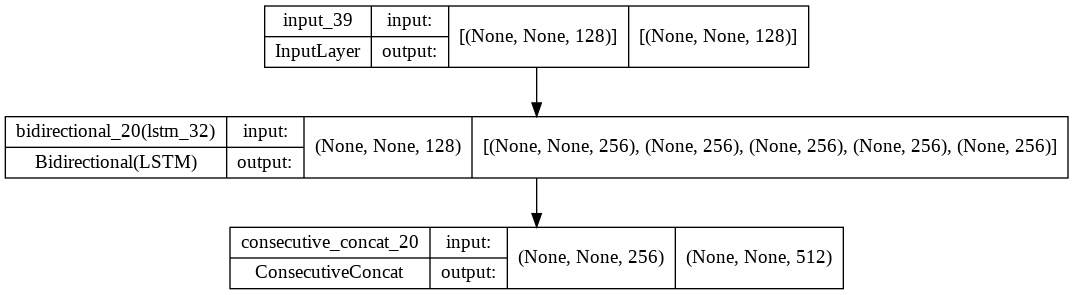

In [ ]:
las.listener.summary()

tf.keras.utils.plot_model(las.listener, show_shapes=True)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, None, 128)    6656        ['input_40[0][0]']               
                                                                                                  
 input_42 (InputLayer)          [(None, 256)]        0           []                               
                                                                                                  
 input_43 (InputLayer)          [(None, 256)]        0           []                               
                                                                                           

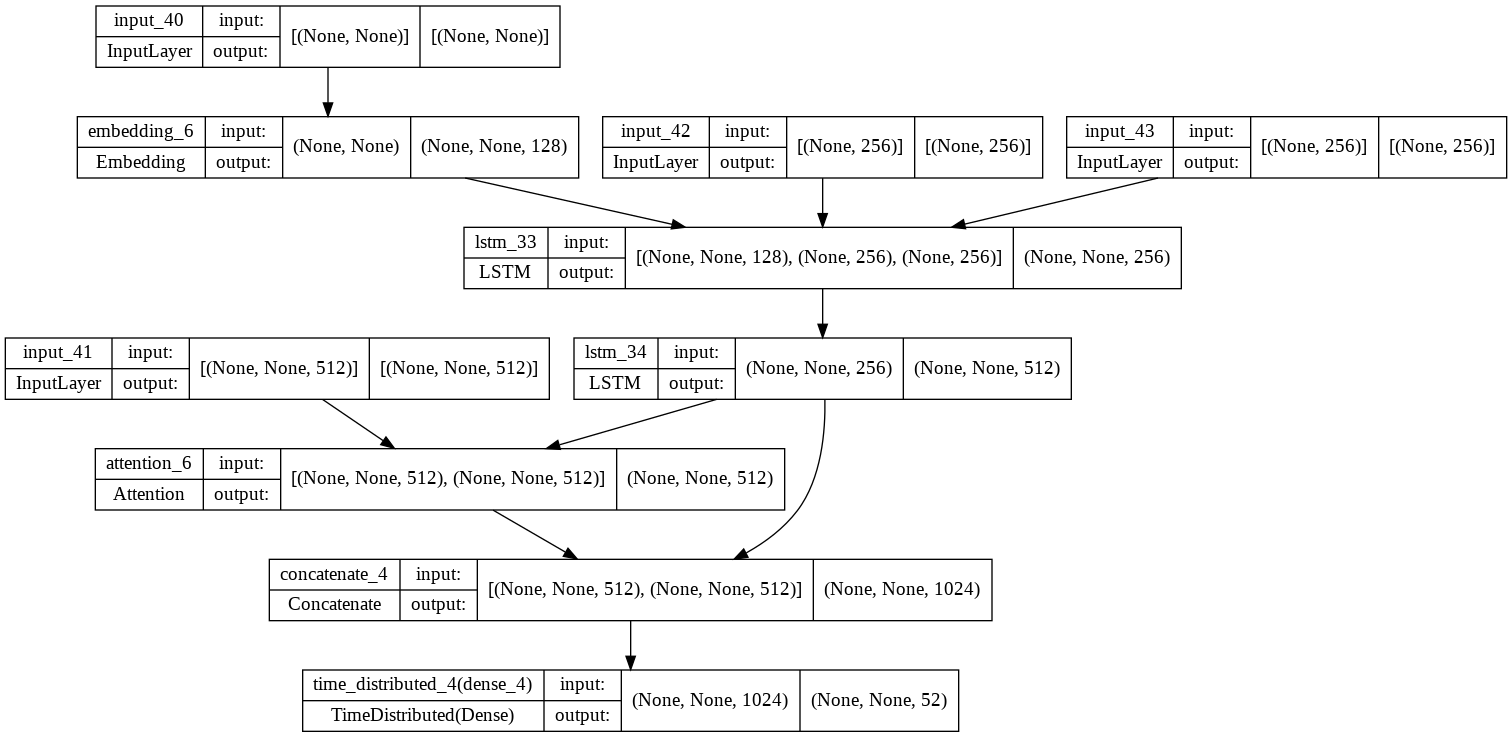

In [ ]:
las.speller.summary()

tf.keras.utils.plot_model(las.speller, show_shapes=True)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, None, 128)]  0           []                               
                                                                                                  
 input_45 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 model_13 (Functional)          [(None, None, 512),  788480      ['input_44[0][0]']               
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                           

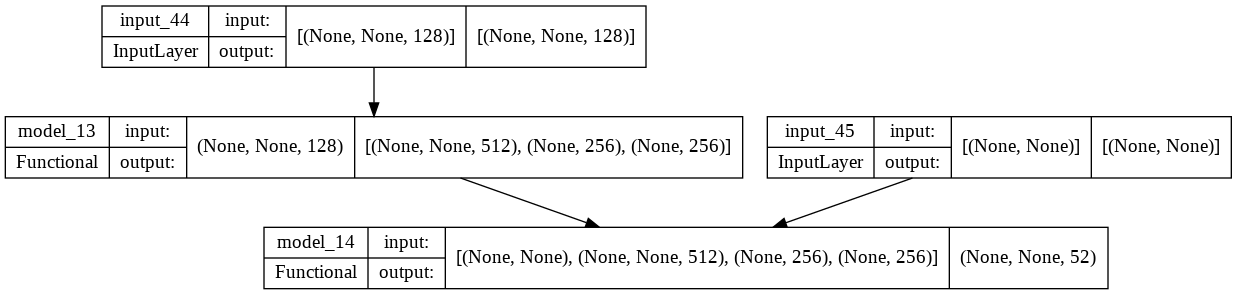

In [ ]:
las.model.summary()

tf.keras.utils.plot_model(las.model, show_shapes=True)

In [ ]:
las.train_model(epochs=50, batch_size=64)

Epoch 1/25
205/205 [==============================] - 2477s 12s/step - loss: 1.5519 - accuracy: 0.5671
Epoch 2/25
205/205 [==============================] - 2500s 12s/step - loss: 1.1535 - accuracy: 0.6597
Epoch 3/25
 24/205 [==>...........................] - ETA: 36:07 - loss: 1.0200 - accuracy: 0.6987